In [1]:
# Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import conorm

In [2]:
# FUNCTIONS: 

# define a function that transforms the sample names to coherent condition names
def sample_to_condition(sample: str) -> str:
    """Transform individual sample name to coherent condition name."""
    if sample.startswith('N'):
        return 'Normoxia'
    elif sample.startswith('A'):
        return 'Anoxia'
    elif sample.startswith('R'):
        return 'Reoxygenation'
    else: 
        raise ValueError(f"Unknown sample name {sample}")

# 1 Import DMR and DESeq data 

In [3]:
# read in DMR data (unique gene ids) 
with open('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_unique_geneids.json', 'r') as f:
    dmr_unique_geneids = json.load(f)

# Import DEseq results
# IMPORT raw data 
deg_na = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_anoxia_normoxia.csv', header=0, sep=',').assign(condition='NvsA')
deg_nr = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_reoxygenation_normoxia.csv', header=0, sep=',').assign(condition='NvsR')
deg_ar = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/comp_anoxia_reoxygenation.csv', header=0, sep=',').assign(condition='AvsR')
deg = pd.concat([deg_na, deg_nr, deg_ar])
deg.rename({'Unnamed: 0': 'geneid'},axis=1,  inplace=True)
deg.set_index('geneid', inplace=True)


# 2 Filter for top 10 genes that were hit by DMR

In [4]:
# Filter deg data to only keep the rows that are in the dmr data (genes that are hit by DMRs)
dmr_genes=[]

for name, df in dmr_unique_geneids.items(): 
    temp = deg.loc[(deg['condition'] == name) & (deg.index.isin(df))]
    dmr_genes.append(temp)
dmr_genes = pd.concat(dmr_genes)


In [5]:
# Sort the data by pvalue and keep the top 3 hits for each condition
dmr_genes.sort_values('pvalue', inplace=True)

top_dmr = []

# for each condition filter the top 10 and save in new df 
for condition, data in dmr_genes.groupby('condition'): 
    # filter for unique gene id and keep first 
    temp = data.drop_duplicates(keep='first') #.iloc[:10]
    top_dmr.append(temp)
top_dmr = pd.concat(top_dmr)

In [6]:
len(top_dmr[['pvalue', 'condition']])

56

# 3 Import feature counts data 

In [7]:
# import fetaure cpounts (gene expression data)
expression = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/9_create_GeneCountsMatrix/gene_matrix_count.csv', sep=',', index_col=0)
# reorder the columns of the expression dataframes
# Specify the desired column order
column_order = ['N1', 'N2', 'N3', 'N7', 'A1', 'A2', 'A4', 'A7', 'R2', 'R3', 'R7', 'R8']
# Reorder the dataframe columns
expression = expression.reindex(columns=column_order)
# filter the rows that have as a sum less than 50 counts
expression = expression[(expression.sum(axis=1) >= 50)]

In [8]:
# data normlization to get TMM data 
expression_tmm = conorm.tmm(expression)

In [9]:
# filter expression df for all the DMR genes
tmm_dmr = expression_tmm[expression_tmm.index.isin(top_dmr.index)]
# reset index 
tmm_dmr.reset_index(inplace=True)

In [10]:
len(tmm_dmr)


50

In [11]:
# convert from long to short format
tmm_dmr = tmm_dmr.melt(id_vars='Geneid', var_name='sample', value_name='measurement')
# write uniform sample name for each condition 
tmm_dmr['condition'] = tmm_dmr['sample'].apply(sample_to_condition)
tmm_dmr

,Geneid,sample,measurement,condition
0,ccar_ub01-g23719,N1,882.971976,Normoxia
1,ccar_ua02-g1919,N1,240.810539,Normoxia
2,ccar_ua02-g2350,N1,163.513329,Normoxia
3,ccar_ub03-g26528,N1,4941.075502,Normoxia
4,ccar_ub03-g26560,N1,215.044802,Normoxia
...,...,...,...,...
595,ccar_ua23-g21428,R8,1896.146019,Reoxygenation
596,ccar_ua25-g22490,R8,904.664880,Reoxygenation
597,ccar_ua25-g22987,R8,3.946194,Reoxygenation
598,ccar_ua25-g23230,R8,100.627936,Reoxygenation


# 4 Normalization of data 

In [12]:
grouped = tmm_dmr.groupby(['Geneid'])

tmm_norm = []

for gene_id, data in grouped: 
    # calculate the mean for normoxia
    mean = data.loc[data.condition == 'Normoxia', 'measurement']
    if len(mean) == 0: 
        continue
    mean = mean.mean() 
    # calculate the geomean in normoxia 
    geomean = stats.gmean(data.loc[data.condition == 'Normoxia', 'measurement'])
    # write the calculated mean into a new column
    data["norm_average"] = mean
    # Determination of relative deviation
    data["rel_deviation"] = data["measurement"]/mean
    tmm_norm.append(data)
tmm_norm = pd.concat(tmm_norm)
tmm_norm

,Geneid,sample,measurement,condition,norm_average,rel_deviation
1,ccar_ua02-g1919,N1,240.810539,Normoxia,250.713773,0.960500
51,ccar_ua02-g1919,N2,300.878397,Normoxia,250.713773,1.200087
101,ccar_ua02-g1919,N3,232.332994,Normoxia,250.713773,0.926686
151,ccar_ua02-g1919,N7,228.833161,Normoxia,250.713773,0.912727
201,ccar_ua02-g1919,A1,110.345942,Anoxia,250.713773,0.440127
...,...,...,...,...,...,...
399,ccar_ub25-g44776,A7,463.359524,Anoxia,564.403031,0.820973
449,ccar_ub25-g44776,R2,646.820354,Reoxygenation,564.403031,1.146026
499,ccar_ub25-g44776,R3,578.132551,Reoxygenation,564.403031,1.024326
549,ccar_ub25-g44776,R7,531.645087,Reoxygenation,564.403031,0.941960


# 5 Significance test

First we have to test if there is an overall significance between the samples 

In [13]:
from scipy.stats import f_oneway
from scipy.stats import alexandergovern

# test if expression changes are significant 
def stats_test(data: pd.DataFrame):
    grouped = data.groupby('Geneid')
    anova_results = pd.DataFrame(columns=['F', 'p'])
    for geneid, data in grouped: 
        if data['rel_deviation'].isna().all(): 
            continue
        samples=[]
        std_dev=[]
        for _, sample in data.groupby('condition'):
            samples.append(sample['rel_deviation'])
            std_dev.append(sample['rel_deviation'].std())
        if np.all(np.isclose(std_dev, np.mean(std_dev), rtol=0.5)):
            test='anova'
            res = f_oneway(*samples)
        else:
            test= 'alexander-govern'
            res = alexandergovern(*samples)
        F,p = res.statistic, res.pvalue
        anova_results.loc[geneid, 'F'] = F
        anova_results.loc[geneid, 'p'] = p
        anova_results.loc[geneid, 'Test'] = test
    return anova_results

In [14]:
# apply the defines significance test onto the dataframe 
stat_res = stats_test(tmm_norm)
stat_res

,F,p,Test
ccar_ua02-g1919,21.911217,0.000348,anova
ccar_ua02-g2350,11.833104,0.003024,anova
ccar_ua05-g5120,11.999092,0.00248,alexander-govern
ccar_ua05-g5369,16.809514,0.000914,anova
ccar_ua05-g5816,1.135709,0.363235,anova
ccar_ua05-g5838,1.394967,0.497837,alexander-govern
ccar_ua06-g6720,1.143462,0.360995,anova
ccar_ua10-g10025,2.414948,0.144679,anova
ccar_ua11-g11397,2.429898,0.296725,alexander-govern
ccar_ua12-g11671,6.791691,0.015924,anova


Now we have established that we have an overall significance, hence we must perform a posthoc test

In [15]:
from scipy.stats import tukey_hsd
from scipy.stats import mannwhitneyu

# perform post-hoc test 
def posthoc_test(data: pd.DataFrame): 
    grouped = data.groupby('Geneid')
    posthoc_results = pd.DataFrame(index=data['Geneid'].unique())
    for geneid, data in grouped: 
        if data['rel_deviation'].isna().all(): 
            continue
        samples=[]
        groups = list(data.groupby('condition').groups.keys())
        names = []
        for i in groups: 
            for j in groups: 
                names.append('p ' + i+j)
        for name, sample in data.groupby(['condition']):
            samples.append(sample['rel_deviation'])
        test = 'tukey_hsd'
        res = tukey_hsd(*samples)
        posthoc_results.loc[geneid,names] = res.pvalue.flatten()
    return posthoc_results


In [16]:
post_res = posthoc_test(tmm_norm)
post_res.drop(columns=['p AnoxiaAnoxia', 'p ReoxygenationReoxygenation', 'p NormoxiaNormoxia', 'p AnoxiaNormoxia', 'p ReoxygenationNormoxia', 'p ReoxygenationNormoxia', 'p ReoxygenationAnoxia'], inplace=True)
post_res

,p AnoxiaReoxygenation,p NormoxiaAnoxia,p NormoxiaReoxygenation
ccar_ua02-g1919,0.066935,0.000270,0.008241
ccar_ua02-g2350,0.004553,0.007529,0.936541
ccar_ua05-g5120,0.091312,0.001898,0.067293
ccar_ua05-g5369,0.308294,0.000853,0.007280
ccar_ua05-g5816,0.425284,0.999964,0.429352
ccar_ua05-g5838,0.284137,0.906551,0.480970
ccar_ua06-g6720,0.426900,0.423238,0.999971
ccar_ua10-g10025,0.311918,0.140101,0.841453
ccar_ua11-g11397,0.713846,0.279248,0.687653
ccar_ua12-g11671,0.020145,0.038071,0.912224


# 5 PLOT (Barplot)

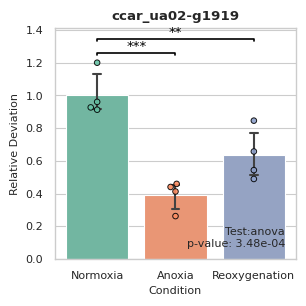

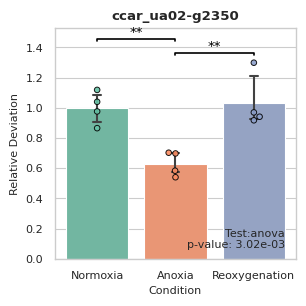

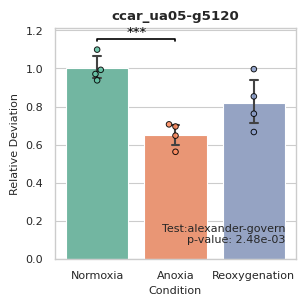

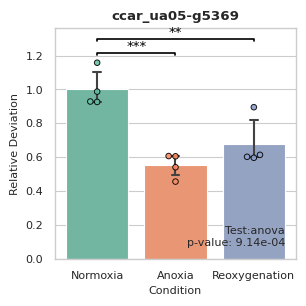

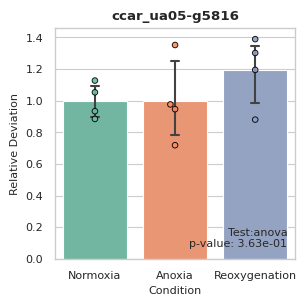

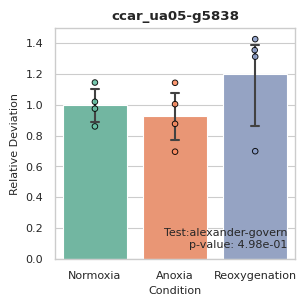

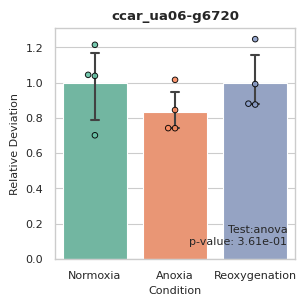

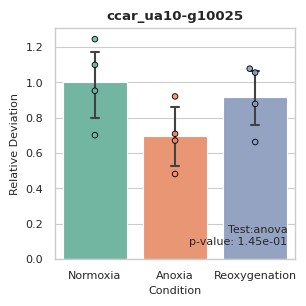

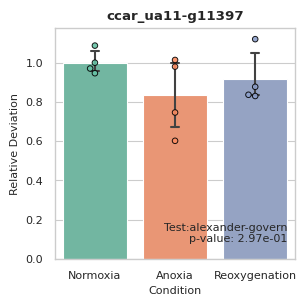

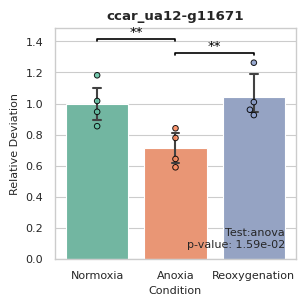

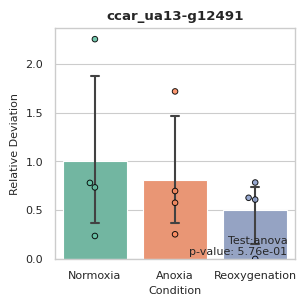

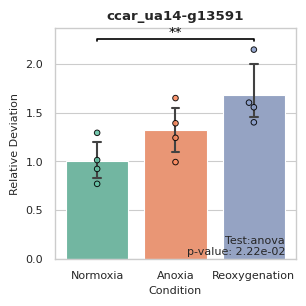

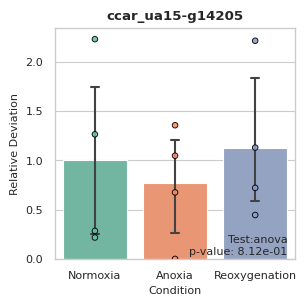

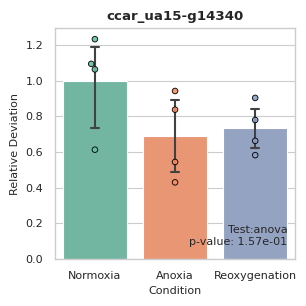

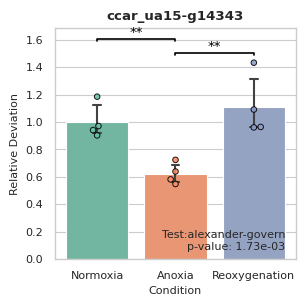

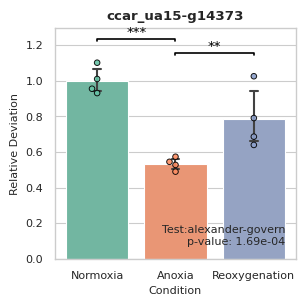

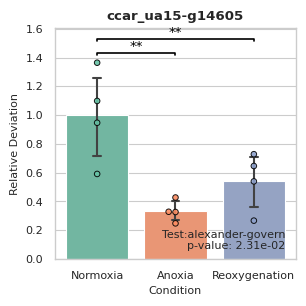

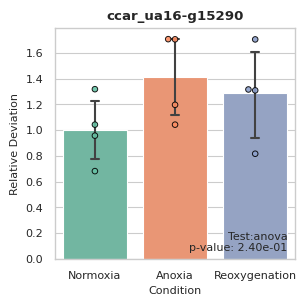

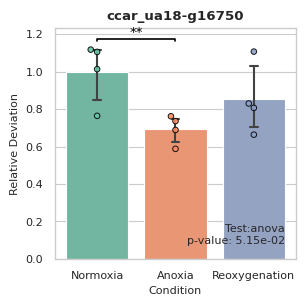

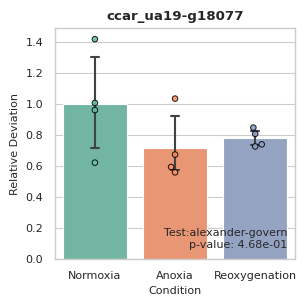

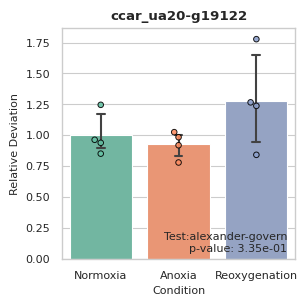

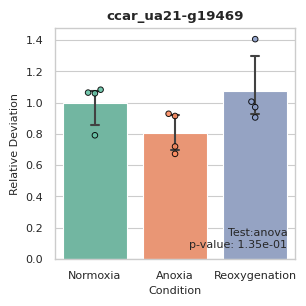

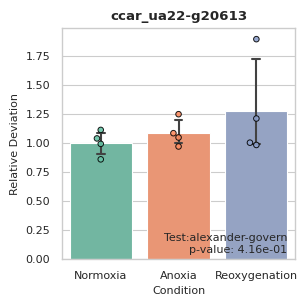

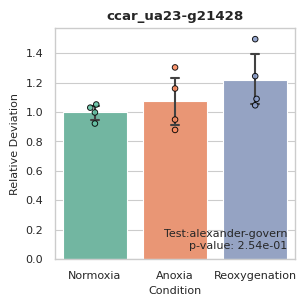

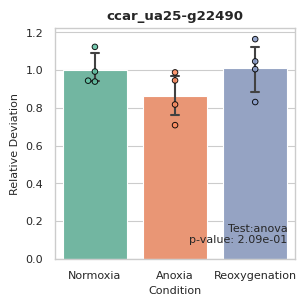

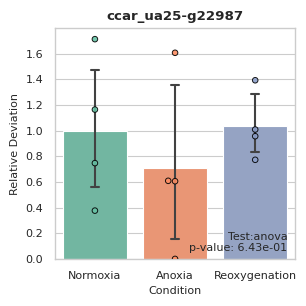

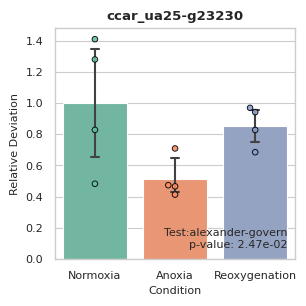

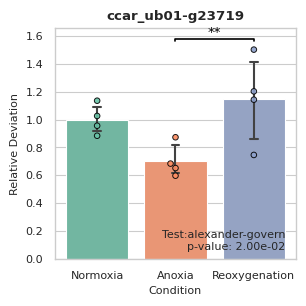

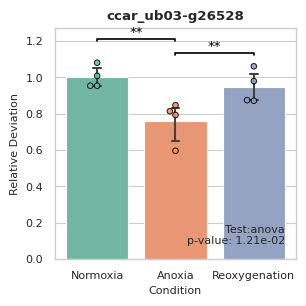

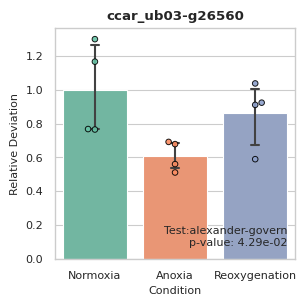

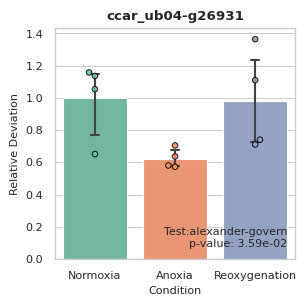

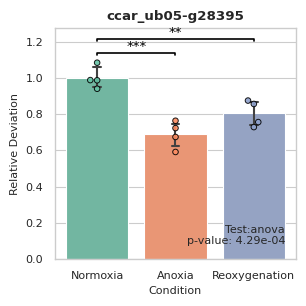

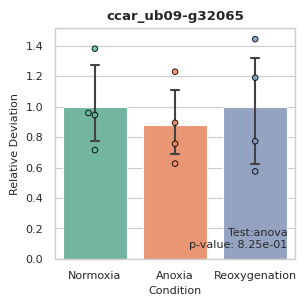

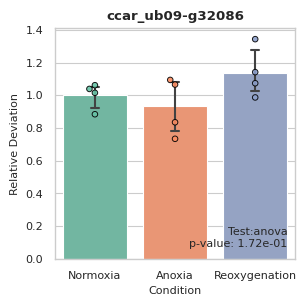

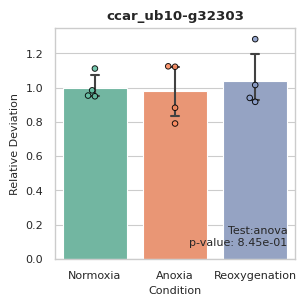

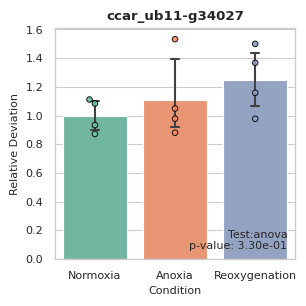

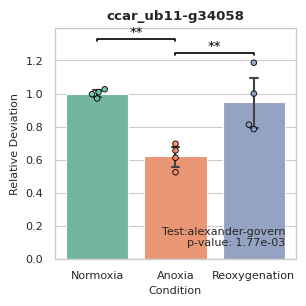

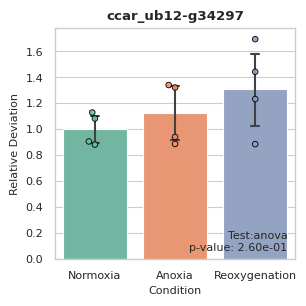

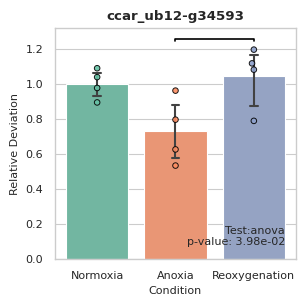

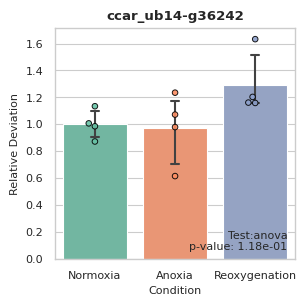

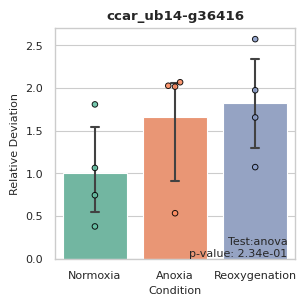

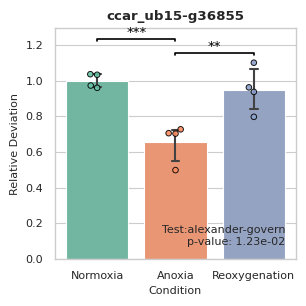

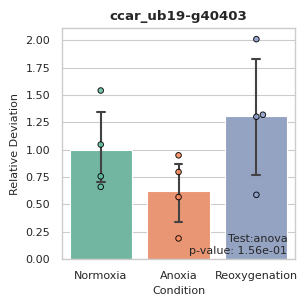

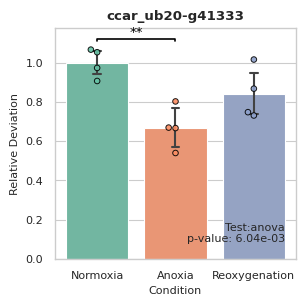

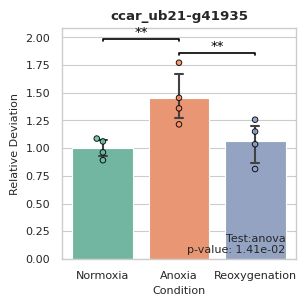

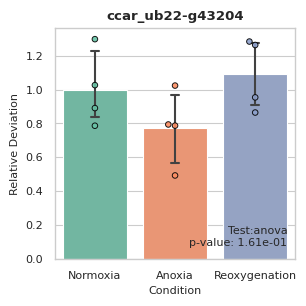

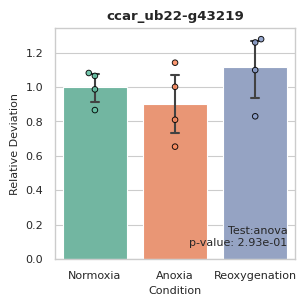

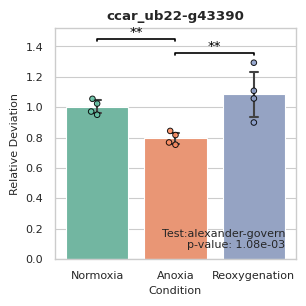

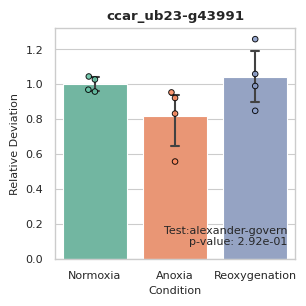

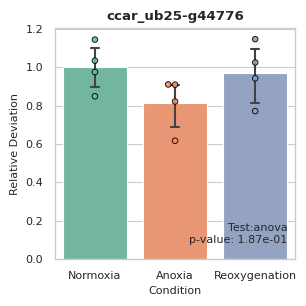

In [17]:
# define sig list 
sig_list = {'p AnoxiaReoxygenation': (1,2),
            'p NormoxiaAnoxia': (0,1),
            'p NormoxiaReoxygenation': (0,2)}

def sig_cat(s):
    if s < 0.0027:
        return "***"
    if s < 0.0455:
        return "**"
    
# set sns colorpallete to colorblind 
sns.set_theme(palette='Set2', style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})

for geneid, data in tmm_norm.groupby('Geneid'): 
    #if stat_res.loc[geneid, 'p'] > 0.05: # skip gened that are not sig in the anova test 
    #    continue
    if np.any(stat_res.loc[geneid, 'Test'] == ''):
        continue

    # PLOT
    plt.figure(figsize=(8/2.54, 8/2.54))
    g = sns.barplot(data=data, x='condition', y='rel_deviation', capsize=0.1, err_kws={"linewidth": 1.5}, hue='condition', legend=False)
    sns.swarmplot(data=data, x='condition', y='rel_deviation', size=4, ax=g, 
                  dodge=False, legend=False, linewidth=0.7, edgecolor="k", alpha=0.9, hue='condition')
    plt.title(geneid, fontdict={'weight': 'bold'})
    plt.ylabel('Relative Deviation')
    plt.xlabel('Condition')
    # significance bars 
    x_pos = np.array([p.get_x() for p in g.patches])
    x_width = np.array([p.get_width() for p in g.patches])
    x_pos = x_pos + (x_width/2)
    y, h, col = data['rel_deviation'].max() * 1.04, data['rel_deviation'].max() * 0.01, 'k'

    offset=0
    sig_info = post_res.loc[geneid, sig_list.keys()]
    sig_info = sig_info.loc[sig_info <= 0.05]
    for name, value in sig_info.items():
        height= np.array([y, y+h, y+h, y]) + offset
        x1, x2 = x_pos[list(sig_list[name])]
        plt.plot([x1, x1, x2, x2], height, lw=1.2, c=col)
        plt.text((x1+x2)*.5, y+h+offset, sig_cat(value), ha='center', va='bottom', color=col)
        offset += data['rel_deviation'].max() * 0.07
    plt.text(2.4, 0.13, f"Test:{stat_res.loc[geneid, 'Test']}\np-value: {stat_res.loc[geneid, 'p']:.2e}", ha='right', va='center', fontsize=8)
    plt.tight_layout()
    plt.savefig(f"12_TMM_plot/{geneid}_TMM_crucian_carp_data_normalized.svg")
    plt.show()
    plt.close()



In [18]:
import pathlib
len(list(pathlib.Path('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/12_TMM_plot/').iterdir()))

50